# Lab Four: The Multi-Layer Perceptron

### *Harrison Noble & Henry Lambson*

___
 
In this lab, you will compare the performance of multi-layer perceptrons programmed via your own various implementations.

__Dataset Selection__

For this assignment, you will be using a specific dataset chosen by the instructor.  This is US Census data available on Kaggle, and also downloadable from the following link: https://www.dropbox.com/s/bf7i7qjftk7cmzq/acs2017_census_tract_data.csv?dl=0

The Kaggle description appears here: https://www.kaggle.com/muonneutrino/us-census-demographic-data/data 

The classification task you will be performing is to __predict, for each county, what the child poverty rate will be.__ You will need to convert this from regression to __four levels of classification__ by quantizing the variable of interest. 

___

## 1 Load, Split & Balance

### 1.1 Load Data & Save to Pandas Data Frame

We will start off by reading in the data into a dataframe, removing all rows with missing values, and visualizing the data after removing rows with missing values.

Text(0.5, 1.0, 'Missing data')

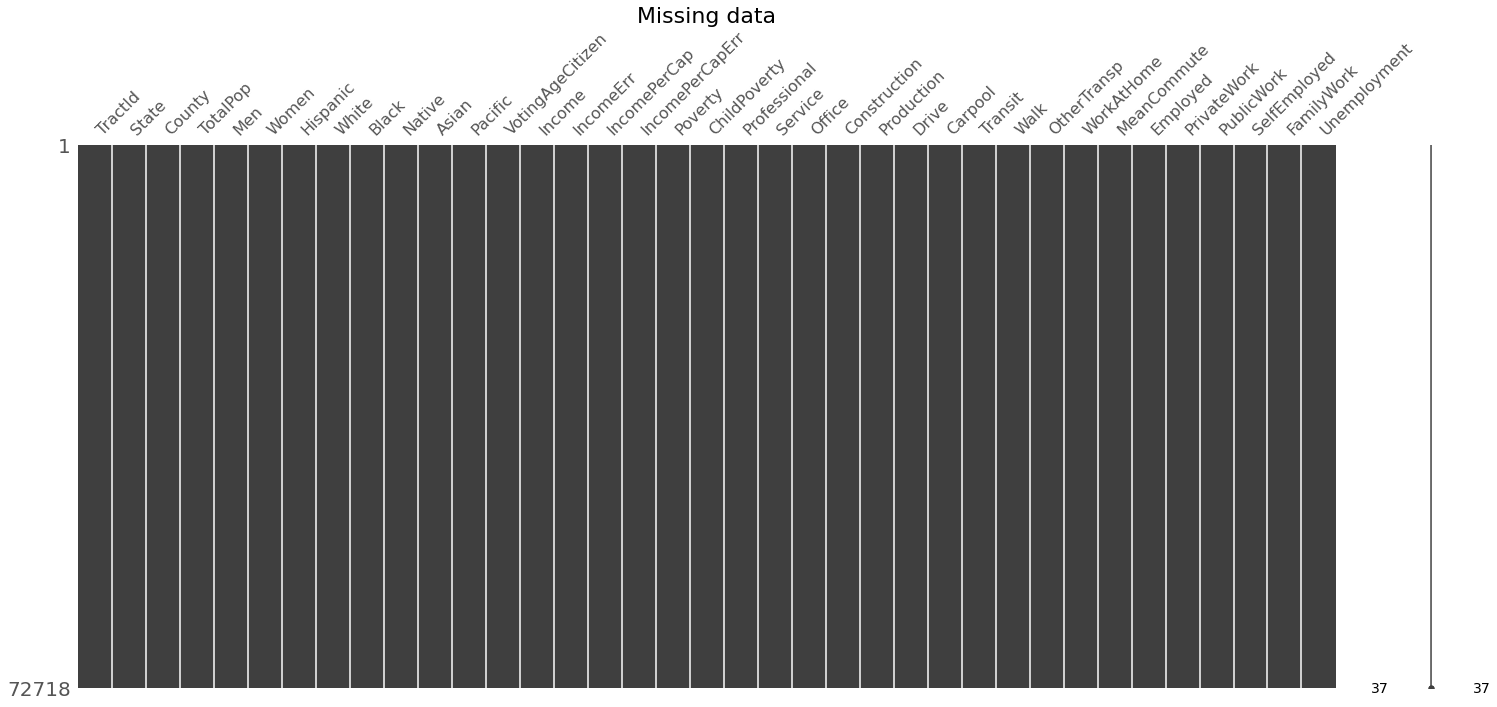

In [41]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import missingno as mn
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

#load data and drop all missing rows
df = pd.read_csv('acs2017_census_tract_data.csv')
df.dropna(inplace=True)

#visualize missingno plot to make sure no missing values
mn.matrix(df)
plt.title("Missing data",fontsize=22)

As we can see above from the missingno plot, we now have no missing values in our data. Additionally, from the above table and plot, we can see that there are a total of 37 features (including ChildPoverty which we will extract later) and 72718 instances in our dataset.

In [42]:
df.select_dtypes(include='object').columns

Index(['State', 'County'], dtype='object')

We can see that columns 'State' and 'County' need to be encoded as integers. Let's do that now. Let's also figure out all the columns we want to remove (aka not necessary in the X data), the columns with continuous data, and the columns with categorical data for ease of preprocessing in section 2.

In [43]:
from sklearn.preprocessing import LabelEncoder

#for every object datatype, encode as integer
for col in df.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

#columns to remove 
#(ChildPoverty b/c thats our prediction task, TractId b/c its not useful, and
#County b/c after running the nn with county still in the data, the nn couldnt converge)
remove = ["ChildPoverty", "TractId", "County"]
#categorical data
categories = ["State"]

#remove 'remove' columns then remove 'categories' columns
continuous = list(df[[col for col in list(df.columns) if col not in remove]])
continuous = [i for i in continuous if i not in categories]

### 1.2 Split Dataset

Now that our dataset consists of only numerical values, let's split the data into 80% for training and 20% for testing. Before we do this, we need to extract the child poverty rate from the dataframe and save it as our "y" value. We believe the ```train_test_split``` method below works fine with our data as once we balance the dataset we will have an even number of data in each category.

In [44]:
from sklearn.model_selection import train_test_split
import numpy as np

#save child poverty rate as y
y = df.ChildPoverty
#drop 'remove' columns from df and save as X
X = df.drop(remove, axis=1)
#train test split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(),
                                                    y.to_numpy(),
                                                    test_size=0.2,
                                                    random_state=1)

### 1.3 Balance Dataset

We now have the data split into testing and training sets. However, the child poverty rate is still a percentange ranging from 0-100%. We need to quantize the child poverty rate into 4 different classes. We also want to balance the dataset so about the same number of instances are within each class.

Lets first quantize the child poverty rate using the percentage value and visualize the instance distribution. For this we will use the following method to quantize the child poverty rate:
- child poverty rate <= 25%: Class 0 (very low child poverty)
- 25% < child poverty rate <= 50%: Class 1 (moderate child poverty)
- 50% < child poverty rate <= 75%: Class 2 (high child poverty)
- child poverty rate > 75%: Class 3 (very high child poverty)

Bins: [  0  25  50  75 100]
Number of instances in each class: [38217 14773  4507   677]


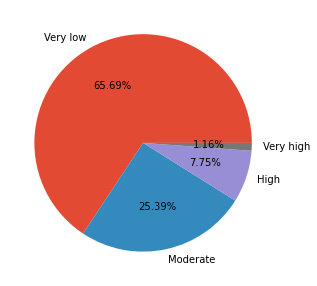

In [45]:
#quantize child poverty training set using above method
y_quant, bins = pd.cut(y_train,
                       bins=[0,25,50,75,100],
                       labels=[0,1,2,3],
                       retbins=True,
                       include_lowest=True)
print('Bins:', bins)

#output number of instances and plot
print('Number of instances in each class:',np.bincount(y_quant))
fig = plt.figure(figsize=(5, 5))
plt.pie(np.bincount(y_quant),
        labels=['Very low', 'Moderate', 'High', 'Very high'],
        autopct='%.2f%%')
plt.show()

This result is not great... we are not even close to balanced. By using the child poverty value we get about 65.5% in very low, 25.5% in moderate, 8% in high, and 1% in very high. If we wanted to balance our dataset using undersampling we would need to have 687 instances in each class (lowest number of class instances), which would remove about 95% of our data... not ideal. We could also oversample, which would add a lot of instances to the smaller classes (classes with lower amount of instances), but this would not accurately reflect our data as the numbers wont be real world statistics. We could also try a combination of both undersampling and oversampling techniques, however, this introduces a lot of overhead we have not learned so far.

Let's try a different method of quantizing the data. In this next method, we quantize the child poverty rate based on quartiles. Since we want to divide the child poverty rate into 4 classes, we can use quartile ranges to do so. To do this, we will use the following method to quantize the child poverty rate:
- child poverty rate <= Q1: Class 0 (very low child poverty)
- Q1 < child poverty rate <= Q2: Class 1 (moderate child poverty)
- Q2 < child poverty rate <= Q3: Class 2 (high child poverty)
- child poverty rate > Q3: Class 3 (very high child poverty)

Where each quartile (Q) represents 25% of the data

Bins: [  0.    6.2  16.4  31.7 100. ]
Number of instances in each class: [14589 14605 14502 14478]


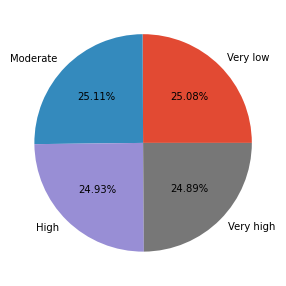

In [46]:
y_quant, bins = pd.qcut(y_train, 4, labels=[0,1,2,3], retbins=True)
print('Bins:', bins)

#output number of instances and plot
print('Number of instances in each class:',np.bincount(y_quant))
fig = plt.figure(figsize=(5, 5))
plt.pie(np.bincount(y_quant),
        labels=['Very low', 'Moderate', 'High', 'Very high'],
        autopct='%.2f%%')
plt.show()

This quantization is much more balanced. Looking at the bins, we can tell that each class is quantized in the following way:
- child poverty rate <= 6.2%: Class 0 (very low child poverty)
- 6.2% < child poverty rate <= 16.4%: Class 1 (moderate child poverty)
- 16.4% < child poverty rate <= 31.7%: Class 2 (high child poverty)
- child poverty rate > 31.7%: Class 3 (very high child poverty)

Looking at these numbers, we determined that this is an adequate way of quantizing the values. Since this method is looking at quartile ranges for the test child poverty values, we compared these quartile ranges with the entire dataset (using the first dataframe output in section 1.1). We deemed this quantization adequate since it accurately represents our dataset as a whole and the child poverty rate percentages this method split the data on seem like a good representation of census statistics [reference 2]. Because of this, we set our ```y_train``` variable equal to the ```y_quant``` variable for this quantization method below.

In [47]:
y_train = y_quant.to_numpy()
print(np.bincount(y_train))

[14589 14605 14502 14478]


__Should balancing of the dataset be done for both the training and testing set? Explain.__

In our case, we want to quantize the testing data using the same exact quatization method as the training data. In our case, we will set the bins to 0, 6.2, 16.4, 31.7, and 100. This will not necessarily result in balanced testing data as the testing data can have different quartile ranges, however, it will quantize our testing data using the exact same quartiles as our training data. We want to do this because any other method may result in testing data not being quantized in the same manner as our training data.

In general, balancing training data is a good idea as it trains the classifier in a way that reduces the risk of memorizing the class that occurs the most. This allows the classifier to "evenly" train across all classes of data. To answer the question if we should balance the testing dataset, the answer is usually no. If we want good generalization performace (that being good performance in the real world), we do not want to have balanced testing data. Real world data is not balanced and therefore not best represent our model. We should obviously use metrics like f-score, precision, and recall on our test data in order to assess the generalized performance on our model. 

The code below quantizes our testing data using the bins specified above:

Bins: [  0.    6.2  16.4  31.7 100. ]
Number of instances in each class: [3640 3728 3573 3603]


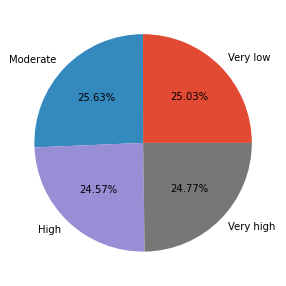

[3640 3728 3573 3603]


In [48]:
y_quant, bins = pd.cut(y_test, 
                       bins=[0, 6.2, 16.4, 31.7, 100.], 
                       labels=[0,1,2,3], 
                       retbins=True,
                       include_lowest=True)
print('Bins:', bins)

#output number of instances and plot
print('Number of instances in each class:',np.bincount(y_quant))
fig = plt.figure(figsize=(5, 5))
plt.pie(np.bincount(y_quant),
        labels=['Very low', 'Moderate', 'High', 'Very high'],
        autopct='%.2f%%')
plt.show()

#save y_quant to y_test
y_test = y_quant.to_numpy()
print(np.bincount(y_test))

Despite what we said above about not balancing the testing data, we need to be able to classify the testing data using the same ranges as our training. Because of this, the  testing data has become relatively balanced but not quite as balanced as our training data. We can see that there is about 0.5-1% more very low and moderate child poverty rates compared to high and very high child poverty rates in our testing set. In our training set, these percentages were much closer to eachother (within 0.25% at max). 

___

## 2 Pre-Processing

### 2.1 Use Example Two-Layer Perceptron Network & Quantify Performance

Below, we implement a two-layer perceptron class with vectorized computing, mini-batching, cross entropy, and Glorot initialization.

In [49]:
from scipy.special import expit
import sys

#implement base TwoLayerPerceptron class
#taken from 08. Practical_NeuralNets
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers"""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        """Get the objective function value"""
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step"""
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation"""
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [50]:
from sklearn.metrics import accuracy_score

#implement TwoLayerPerceptron class w/ mini batching
#taken from 08. Practical_NeuralNets
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data with mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        #start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [51]:
#implement TwoLayerPerceptron class w/ mini batching & cross entropy
#taken from 08. Practical_NeuralNets
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        '''Compute gradient step using backpropagation'''
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [52]:
#implement TLP class w/ mini batching, cross entropy & Glorot initialization
#taken from 08. Practical_NeuralNets
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

The massive chunk of code above creates the TLP with mini-batching, vectorized computation, cross entropy, and Glorot weight initialization (each new class definition builds off the previous ones). We decided to keep them seperate for clarity. 

Let's now test out the TLP implementation on the dataset and quantify the performance using accuracy.

In [53]:
#use print_result function from class to 
plt.style.use('ggplot')

def print_result(nn, X_train, y_train, X_test, y_test, title="", color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
    
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)
    
    #plot cost
    plt.subplot(1,2,2)
    cost_avgs = [np.mean(x) for x in nn.cost_]
    plt.plot(range(len(cost_avgs)), cost_avgs, label='Avg Cost', color=color)
    
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Epoch: 40/40

CPU times: user 36.2 s, sys: 25.7 s, total: 1min 1s
Wall time: 15.7 s
Done!
Unedited Data :
Resubstitution acc: 0.2512290714064702
Validation acc: 0.2502062706270627


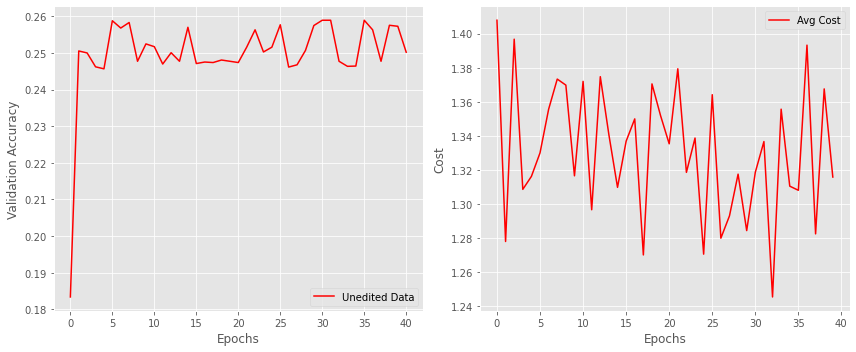

In [54]:
#use params from class
vals = {'n_hidden':30, 
        'C':0.1, 'epochs':40, 'eta':0.001, 
        'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
        'shuffle':True, 'random_state':1}

nn1 = TLPBetterInitial(**vals)

%time nn1.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print('Done!')

print_result(nn1, X_train, y_train, X_test, y_test,
             title="Unedited Data")
plt.show()

This perceptron performs very poor. It's sitting around 25% accuracy after 40 epochs. We expected this due to the data not being normalized or one hot encoded whatsoever. Let's see how the model performs after normalizing continuous features now. (We will compare the cost graphs of the 3 datasets below). 

### 2.2 Normalize Continuous Numeric Feature Data

Here we use the sklearn StandardScaler to normalize all the continuous data. We then split that data into a train set and a test set (using the same random state as our first train-test-split in order to keep the ordering of the instances the same). We save the new train and test data into different variable names so we can compare all the models later. 

In [55]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

#normalize continuous features
X_normalized = X.copy()
X_normalized[continuous] = std_scaler.fit_transform(X_normalized[continuous])

#split normalized X data using same random state as first train test split
X_train_n, X_test_n = train_test_split(X_normalized.to_numpy(),
                                       test_size=0.2,
                                       random_state=1)

Epoch: 40/40

CPU times: user 34 s, sys: 23.2 s, total: 57.2 s
Wall time: 14.5 s
Done!
Normalized Data :
Resubstitution acc: 0.6174751607247224
Validation acc: 0.6191556655665567


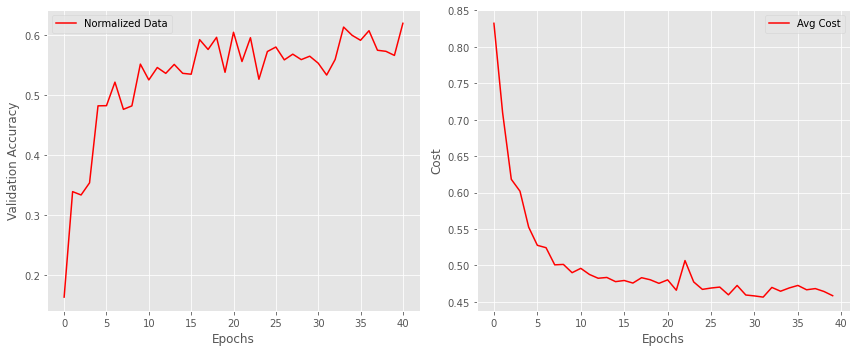

In [56]:
nn2 = TLPBetterInitial(**vals)

%time nn2.fit(X_train_n, y_train, print_progress=1, XY_test=(X_test_n, y_test))
print('Done!')

print_result(nn2, X_train_n, y_train, X_test_n, y_test,
             title="Normalized Data")
plt.show()

That's what we like to see... improvement! This model is performing about 25-30% better than our previous model just by normalizing the continuous features. Let's see what normalization and one hot encoding can do for our accuracy.

### 2.3 One Hot Encode Categorical Data & Normalize Continuous Numeric Features

Lastly, we will one hot encode the categorical data. We do this by taking the normalized data, looping through the 'categories' list, and using the ```pd.get_dummies``` function to one hot encode those column(s). This data is also train-test-split (using the same random state as the previous two splits) and saved to seperate variables so we can compare in the next section. 

In [57]:
#copy over normalized data
X_norm_enc = X_normalized.copy()

for col in categories:
    X_norm_enc = pd.concat([X_norm_enc, pd.get_dummies(X_norm_enc[col], prefix=col)],
                           axis=1)
    X_norm_enc.drop([col], axis=1, inplace=True)

#split normalized & one hot X data using same random state as first train test split
X_train_ne, X_test_ne = train_test_split(X_norm_enc.to_numpy(),
                                         test_size=0.2,
                                         random_state=1)

Epoch: 40/40

CPU times: user 44.5 s, sys: 28.6 s, total: 1min 13s
Wall time: 18.7 s
Done!
Normalized & One Hot Encoded Data :
Resubstitution acc: 0.7340392615257675
Validation acc: 0.7378300330033003


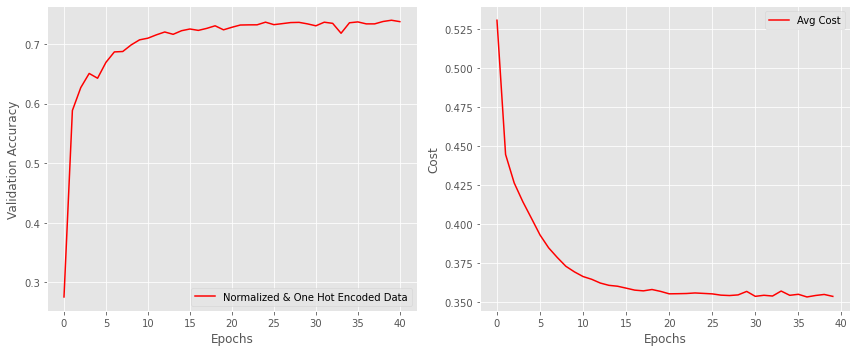

In [58]:
nn3 = TLPBetterInitial(**vals)

%time nn3.fit(X_train_ne, y_train, print_progress=1, XY_test=(X_test_ne, y_test))
print('Done!')

print_result(nn3, X_train_ne, y_train, X_test_ne, y_test,
             title="Normalized & One Hot Encoded Data")
plt.show()

Wow! Both normalization and one hot encoding brought our accuracy way up to 72%. By just one hot encoding the 'State' feature, we were able to increase our accuracy another 20% compared to just normalizing continuous features.

### 2.4 Compare Performance of the Three Trained Models

Let's compare the performance of our three trained models below. We start off by graphing the accuracies of each one on the same plot as a visual reference.

Unedited Data Loss :
Resubstitution acc: 0.2512290714064702
Validation acc: 0.2502062706270627
Normalized Data Loss :
Resubstitution acc: 0.6174751607247224
Validation acc: 0.6191556655665567
Normalized & One Hot Encoded Data Loss :
Resubstitution acc: 0.7340392615257675
Validation acc: 0.7378300330033003


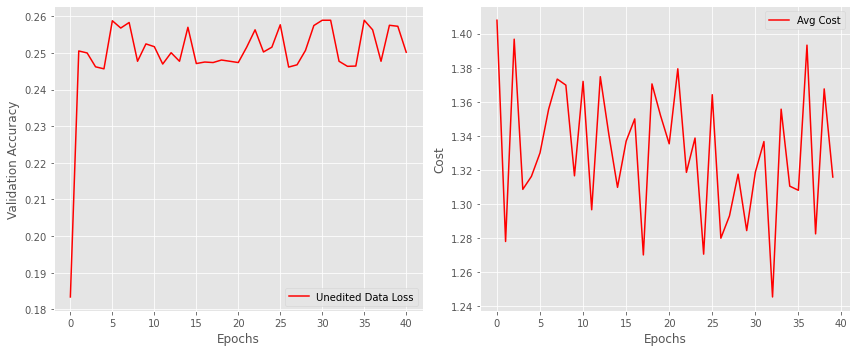

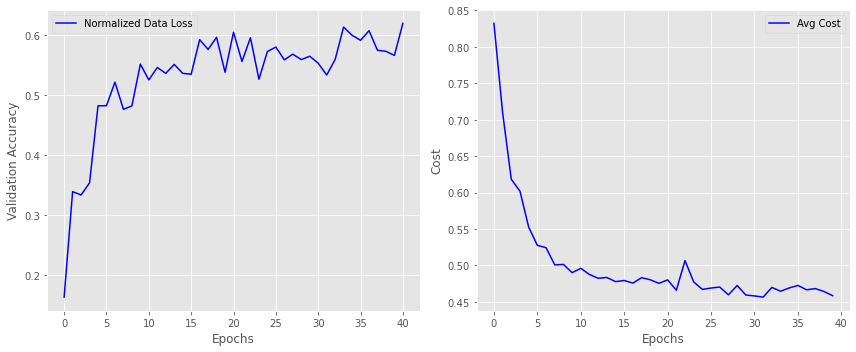

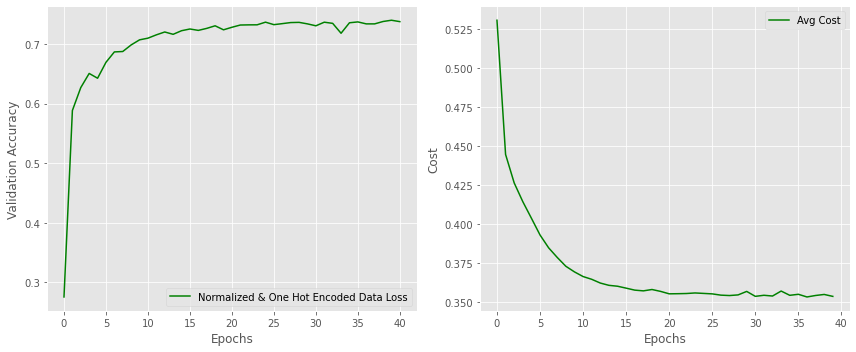

In [59]:
print_result(nn1, X_train, y_train, X_test, y_test,
             title="Unedited Data Loss", color='red')
print_result(nn2, X_train_n, y_train, X_test_n, y_test,
             title="Normalized Data Loss", color='blue')
print_result(nn3, X_train_ne, y_train, X_test_ne, y_test,
             title="Normalized & One Hot Encoded Data Loss", color='green')
plt.show()

Our three models have vastly different performances. Using the raw dataset (excluding the removed columns), the model was about as good as randomly picking a classification. We believe this is due to the nature of these numbers. With the raw dataset, there is very high variablility with each feature value. Because there is such a wide range, our first model struggles to actually learn. The cost is very high and seems to be jumping around at random with each epoch. This signifies that the training is not converging fully, however, after we processed the data, the cost graphs looked much better. 

Our second model performs better than our first model, however it does not perform great. This model is able to predict more accurately because the continuous data is normalized, which removes that high variability factor in each of the continuous features. Normalizing the continuous features removes the wide range which allows the model better learn since there are no continuous features "dominating" the others. However, there is still an issue with the 'State' feature since its value range (0-51) is much higher than the other data. This can introduce bias in the model, causing it to predict child poverty rates based on states. Once the data has been normalized, we can see that the cost is much lower and follows a downward path until it levels off at around 0.45. 

To fix this, we must one hot encode state since it is categorical data. One hot encoding removes the wide value range in the 'State' feature by introducing more columns into the dataset (in our case 51 new columns). These new columns will contain all 0's except one column, which will contain a 1. By doing this, the model will no longer show bias towards the 'State' feature because that wide value range is reduced to 0 or 1. This caused our model to achieve around a 73% accuracy on the testing dataset, which is about 20% higher than the normalized data and about 50% higher than our raw data. With the categorical data one hot encoded, the cost is even lower than before and follows a better curve until it levels off at just over 0.35. 

Let's get into some statistical tests to see if the final network is statistically better than the others.

In [65]:
yhat_1, yhat_2, yhat_3 = nn1.predict(X_test), nn2.predict(X_test_n), nn3.predict(X_test_ne)

err1 = 1 - accuracy_score(yhat_1, y_test)
err2 = 1 - accuracy_score(yhat_2, y_test)
err3 = 1 - accuracy_score(yhat_3, y_test)

d = np.abs(err2 - err1)
var = (err1 * (1-err1)/X_test.size) + (err2 * (1-err2)/X_test_n.size)
print('Confidence interval of model 2 and 1:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

d = np.abs(err3 - err1)
var = (err1 * (1-err1)/X_test.size) + (err3 * (1-err3)/X_test_ne.size)
print('Confidence interval of model 3 and 1:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

d = np.abs(err3 - err2)
var = (err2 * (1-err2)/X_test_n.size) + (err3 * (1-err3)/X_test_ne.size)
print('Confidence interval of model 3 and 2:', d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

Confidence interval of model 2 and 1: 0.3671357482755571 0.3707630416034308
Confidence interval of model 3 and 1: 0.48618900171649776 0.48905852303597747
Confidence interval of model 3 and 2: 0.11711456574839348 0.12023416912509381


Looking at these confidence intervals, none of them contain zero which means the difference of error rates between the models are statistically significant. This means there are statistically significant differences as we normalize and one hot encode the data (with 95% confidence). 

We will now use the normalized and one hot encoded dataset for the remainder of the lab. We save the normalized and one hot encoded data to our ```X_train``` and ```X_test``` variables below:

In [66]:
X_train = X_train_ne
X_test = X_test_ne

___

## 3 Modeling

### 3.1 Add Support for Third Layer in Multi-Layer Perceptron

Now lets expand on our two-layer perceptron by adding support for a third layer. We found the best way to go about this would be adding a parameter in the constructor called ```layers``` which specifies the number of layers to create. To incorporate extra layers we are going to edit multiple functions.

In [67]:
#implement MLP without adaptive learning technique
class MultiLayerPerceptronBase:
    def __init__(self, layers=3, n_hidden=30, C=0.0, epochs=500, eta=0.001, 
                 random_state=None, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.layers = layers #<--- save number of layers
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T    
        return onehot
    
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization"""
        W = [] #<--- need list of weights now
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W.append(np.random.uniform(-init_bound, 
                                   init_bound,
                                   (self.n_hidden, self.n_features_ + 1)))
        W[0][:,:1] = 0
        
        #layers-2 b/c first and last layers created differently
        for _ in range(self.layers-2):
            init_bound = 4*np.sqrt(6. / (2*self.n_hidden + 1))
            W.append(np.random.uniform(-init_bound, 
                                       init_bound,
                                       (self.n_hidden, self.n_hidden + 1)))
            W[-1][:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_output_ + self.n_hidden + 1))
        W.append(np.random.uniform(-init_bound, 
                                   init_bound,
                                   (self.n_output_, self.n_hidden + 1)))
        W[-1][:,:1] = 0
        
        return W
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W): #<--- pass in weight list
        """Compute L2-regularization cost"""
        #need to get weights for each layer
        total_w = 0
        for weight in W:
            total_w += np.mean(weight[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(total_w)
    
    def _cost(self,A,Y_enc,W): #<--- pass in weight list and A 
        """Get the objective function value"""
        #use A[-1] to get last value in list
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A[-1])+(1-Y_enc)*np.log(1-A[-1]))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W): #<--- pass in weight list
        """Compute feedforward step"""
        #A and Z are now lists
        A = []
        Z = []
        
        A.append(self._add_bias_unit(X, how='column').T)
        
        #do feed forward for all the middle layers
        for layer in range(self.layers - 1):
            Z.append(W[layer] @ A[layer])
            A.append(self._add_bias_unit(self._sigmoid(Z[layer]), how='row'))
        
        #feed forward for output layer
        Z.append(W[-1] @ A[-1])
        A.append(self._sigmoid(Z[-1]))
        
        return A, Z
    
    def _get_gradient(self, A, Z, Y_enc, W):
        """Compute gradient step using backpropagation"""
        #gradient and sensitivity are now lists
        grads = []
        V = []
        for _ in range(self.layers):
            grads.append(0)
            V.append(0)

        #vectorized backpropagation
        #calc last sensitivity and gradient
        V[-1] = A[-1] - Y_enc
        grads[-1] = V[-1] @ A[-2].T
        grads[-1][:, 1:] += W[-1][:, 1:] * self.l2_C
        
        #calc remaining sensitivities and gradients in reverse order
        for i in reversed(range(self.layers-1)):
            V[i] = A[i+1]*(1-A[i+1])*(W[i+1].T @ V[i+1])
            grads[i] = V[i][1:,:] @ A[i].T
            grads[i][:, 1:] += W[i][:, 1:] * self.l2_C
            V[i] = V[i][1:,:]
        
        return grads
    
    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch (no adaptive learning)"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        
        #create variable to store avg gradients for each epoch
        self.avg_grads_ = []
        for _ in range(self.layers):
            self.avg_grads_.append([])
        
        for i in range(self.epochs):
            
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            #need to store the avg gradients in each mini batch
            grads = []
            for _ in range(self.layers):
                grads.append([])
            
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)

                cost = self._cost(A, Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradients = self._get_gradient(A, Z, Y_enc[:, idx], self.W)
                
                #get average magnitude of the gradient for each layer in minibatch
                for index in range(len(grads)):
                    grads[index].append(np.mean(gradients[index]))
                    
                #update weights (no adaptive learning)
                for index in range(len(gradients)):
                    self.W[index] -= (self.eta * gradients[index])
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
            #get average magnitude of the gradient for each layer
            for index in range(len(self.avg_grads_)):
                self.avg_grads_[index].append(np.mean(grads[index]))
                
        return self

We decided to create a class that was able to take in a new parameter ```layers```, that allows us to specify how many layers we want our perceptron to be. We did this so that we would not need to constantly update the code to support the 4 and 5 layer perceptron later on. Because of this, we needed to make the class compatable with any number of layers we chose, so we had to rework these functions: ```_initialize_weights```, ```_L2_reg```, ```_cost```, ```_feedforward```, ```_get_gradient```, and ```fit```. We changed ```W```, ```A```, and ```Z``` to be lists that would be sized according to how many layers we are using, as well as the final gradients we calculate.   

Epoch: 40/40

CPU times: user 1min 9s, sys: 44.7 s, total: 1min 53s
Wall time: 29.1 s
Done!
3 Layer Perceptron :
Resubstitution acc: 0.7278337401588338
Validation acc: 0.7303355335533553


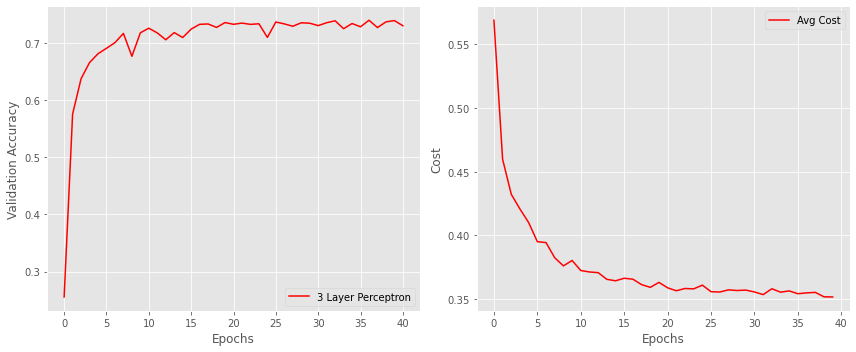

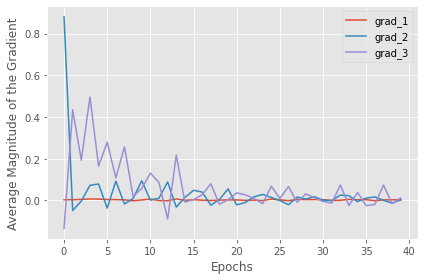

In [68]:
vals = {'layers':3, 'n_hidden':30, 'C':0.1, 'epochs':40, 'eta':0.001, 
        'minibatches':50, 'shuffle':True, 'random_state':1}

nn_3_layer = MultiLayerPerceptronBase(**vals)
%time nn_3_layer.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print('Done!')

print_result(nn_3_layer, X_train, y_train, X_test, y_test, title="3 Layer Perceptron")
plt.show()

for i in range(len(nn_3_layer.avg_grads_)):
    plt.plot(range(len(nn_3_layer.avg_grads_[0])), 
             nn_3_layer.avg_grads_[i], 
             label="grad_"+str(i + 1))
    
plt.ylabel('Average Magnitude of the Gradient')     
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.show()

As we can see from Validation accuracy graph, our accuracy is similar to that of the 2 layer perceptron from earlier. We believe that there was not much improvement due to the lack of a adaptive learning technique for the neural network. Because of this, we think that the fourth and fifth layers will only see minor improvements as well until we do implement an adaptive learning technique. Looking at the Cost graph, we can see that as more epochs are processed, the cost drops significanly until it begins to plataeu at around 15 epochs at a little over 0.35. Finally looking at the Average Magnitude of the Gradient graph, we can see that gradients 2 and 3 converge to 0 also at around 15 epochs. Gradient 1 seems to have suffered from the fact that we are missing an adaptive learning technique, so it begins and stays at 0.  

### 3.2 Add Support for Fourth Layer

To add support for the 4th layer, all we need to do is change ```vals['layers']``` to 4.

Epoch: 40/40

CPU times: user 1min 38s, sys: 1min 4s, total: 2min 42s
Wall time: 42.5 s
Done!
4 Layer Perceptron :
Resubstitution acc: 0.7351565991680132
Validation acc: 0.7364548954895489


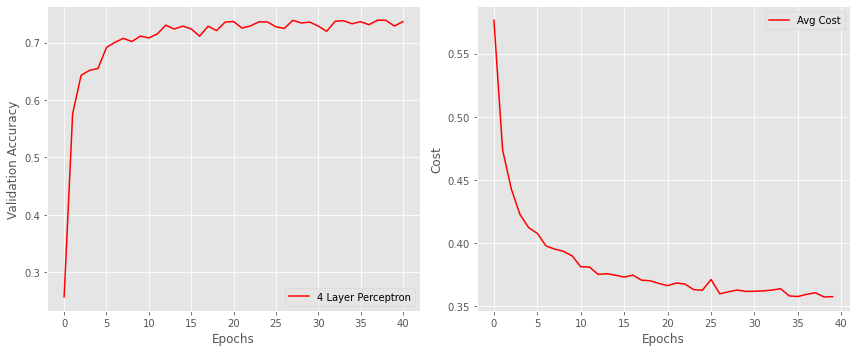

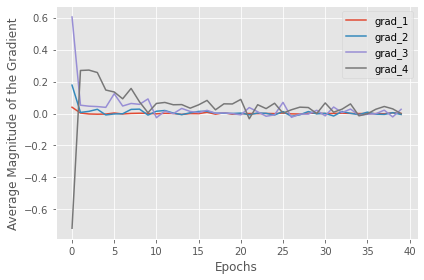

In [69]:
vals['layers'] = 4

nn_4_layer = MultiLayerPerceptronBase(**vals)
%time nn_4_layer.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print('Done!')

print_result(nn_4_layer, X_train, y_train, X_test, y_test, title="4 Layer Perceptron")
plt.show()

for i in range(len(nn_4_layer.avg_grads_)):
    plt.plot(range(len(nn_4_layer.avg_grads_[0])), 
             nn_4_layer.avg_grads_[i], 
             label="grad_"+str(i + 1)) 
    
plt.ylabel('Average Magnitude of the Gradient')     
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.show()

As we expected based off of the 3 layer perceptron's results, the accuracy has improved with the 4th layer, but only slightly. The cost graph is also largely the same, with the curve levelling off at around 15 epochs at just over 0.35. Gradients 4, 3, and 2 converge to 0, with 3 and 2 converging slightly faster than 4, however it seems that gradient 2 is also beginning to suffer as gradient 1 has been. We hope that our adaptive learning technique can help alleviate this later on.

### 3.3 Add Support for Fifth Layer

To add support for the 5th layer, all we need to do is change ```vals['layers']``` to 5. 

Epoch: 40/40

CPU times: user 1min 47s, sys: 1min 9s, total: 2min 56s
Wall time: 45.1 s
Done!
5 Layer Perceptron :
Resubstitution acc: 0.7343314882937395
Validation acc: 0.7370049504950495


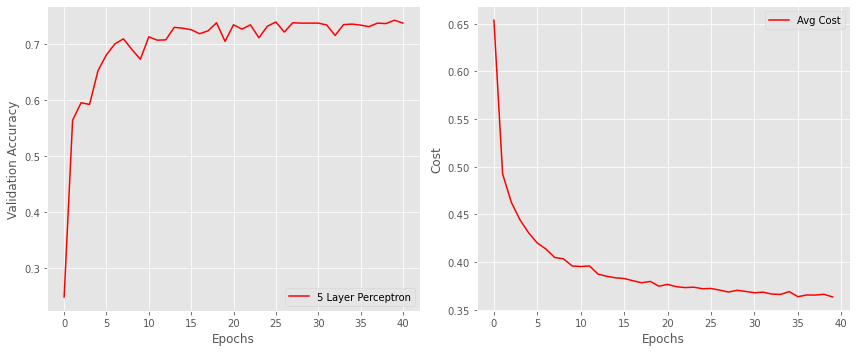

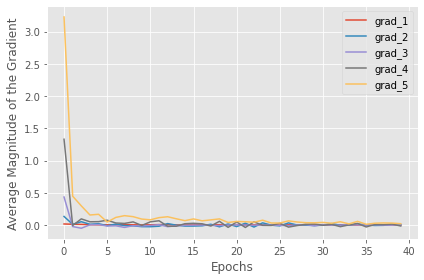

In [70]:
vals['layers'] = 5

nn_5_layer = MultiLayerPerceptronBase(**vals)
%time nn_5_layer.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print('Done!')

print_result(nn_5_layer, X_train, y_train, X_test, y_test, title="5 Layer Perceptron")
plt.show()

for i in range(len(nn_5_layer.avg_grads_)):
    plt.plot(range(len(nn_5_layer.avg_grads_[0])), 
             nn_5_layer.avg_grads_[i], 
             label="grad_"+str(i + 1)) 
    
plt.ylabel('Average Magnitude of the Gradient')     
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.show()

Once again, our validation accuracy has gone up, but just slightly. The cost graph is largely the same, and the gradients begin convering to 0 with gradients 2 a 1 not making too much of an impact. 

### 3.4 Implement Adaptive Learning Technique on Five Layer Network

We decided to implement AdaGrad by adding the ```epsilon``` arguement to the constructor. We then use ```epsilon``` in the fit function in order to implement a cooling rate for ```eta```. We then needed to create a ```G_k``` variable (same size of each weight) and a ```G_prev``` variable (which we first initialize to 0). For the weight updates, we use the formula provided in the sides and update ```G_prev``` to be ```G_k``` after all calculations/updates have been made. 

In [91]:
#MLP with adaptive learning rate
class AdaptiveMultiLayerPerceptron(MultiLayerPerceptronBase):
    def __init__(self, epsilon=0.0, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch (adaptive learning)"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        
        #create 
        self.avg_grads_ = []
        for _ in range(self.layers):
            self.avg_grads_.append([])
            
        G_k = []
        rho = []
        for w in self.W:
            G_k.append(np.zeros(w.shape))
            rho.append(np.zeros(w.shape))
        G_prev = 0

        for i in range(self.epochs):
            # adaptive learning rate
            eta = self.eta / (1 + self.epsilon * i)
            
            #need to store the gradients
            grads = []
            for _ in range(self.layers):
                grads.append([])
            
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                #use A[-1] to get last A value
                cost = self._cost(A, Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradients = self._get_gradient(A, Z, Y_enc[:, idx], self.W)
                
                #get average magnitude of the gradient for each layer
                for index in range(len(gradients)):
                    grads[index].append(np.mean(gradients[index]))
                    
                #update weights (adaptive learning rate)
                for index in range(len(gradients)):
                    if i == 0:
                        G_k[index] = np.add(0, np.square(gradients[index]))
                    else:
                        G_k[index] = np.add(G_prev[index], np.square(gradients[index]))
                    rho[index] = np.divide(eta, np.sqrt(np.add(G_k[index], self.epsilon)))
                    rho[index] = np.multiply(rho[index], gradients[index])
                    self.W[index] -= rho[index]
                G_prev = G_k
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
            #get average magnitude of the gradient for each layer
            for i in range(len(self.avg_grads_)):
                self.avg_grads_[i].append(np.mean(grads[i]))
        
        return self

Epoch: 40/40

CPU times: user 1min 38s, sys: 1min 2s, total: 2min 41s
Wall time: 40.8 s
Done!
5 Layer Perceptron w/ Adaptive Learning :
Resubstitution acc: 0.7422903702685049
Validation acc: 0.740924092409241


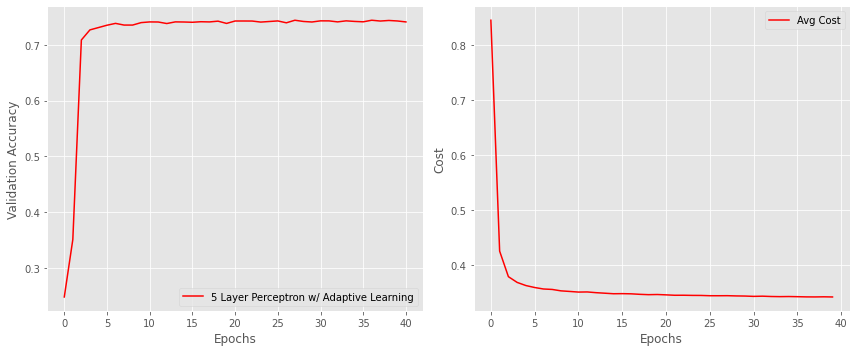

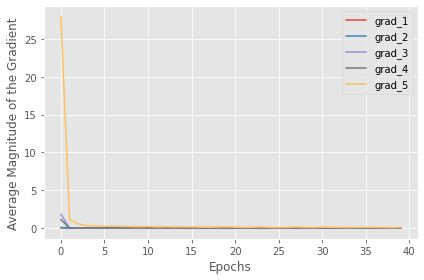

In [94]:
vals = {'layers':5, 'epsilon':1e-10, 'n_hidden':30, 'C':0.1, 'epochs':40, 
        'eta':0.1, 'minibatches':50, 'shuffle':True, 'random_state':1}

nn_adaptive = AdaptiveMultiLayerPerceptron(**vals)
%time nn_adaptive.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print('Done!')

print_result(nn_adaptive, X_train, y_train, 
             X_test, y_test, title="5 Layer Perceptron w/ Adaptive Learning")
plt.show()

for i in range(len(nn_adaptive.avg_grads_)):
    plt.plot(range(len(nn_adaptive.avg_grads_[0])), 
             nn_adaptive.avg_grads_[i], 
             label="grad_"+str(i + 1)) 
    
plt.ylabel('Average Magnitude of the Gradient')     
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.show()

After long trial and error (and most of our sanity), we were able to successfully implement AdaGrad. We struggled with low accuracy (around 56%) and high cost (around 0.6) for a while before playing around with the parameter values. Out of pure luck, we decided to pick 1e-10 for the ```epsilon``` parameter (before it was 1e-8) and 0.1 for the ```eta``` parameter (before it was 0.001). We now have a validation accuracy of around 74% (compared to 73.7% with our previous best model) and our costs are about the same (if not slightly better than our previous best model). 

The biggest improvement of this model is how the gradients converge so quickly instead of bouncing around. We think this gives the AdaGrad model the slight upper hand against all of our other models. 

Let's now do some statistical analysis on our prevous 5 layer model and this model to see if there is any statistical difference between the two.

In [96]:
yhat_1, yhat_2 = nn_5_layer.predict(X_test), nn_adaptive.predict(X_test)

err1 = 1 - accuracy_score(yhat_1, y_test)
err2 = 1 - accuracy_score(yhat_2, y_test)
print('Error rate of 5 layer model', err1)
print('Error rate of 5 layer AdaGrad model', err2, '\n')

d = np.abs(err2 - err1)
var = (err1 * (1-err1)/X_test.size) + (err2 * (1-err2)/X_test.size)
print('Confidence interval of 5 layer model and 5 layer AdaGrad model:', 
      d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

Error rate of 5 layer model 0.26299504950495045
Error rate of 5 layer AdaGrad model 0.25907590759075905 

Confidence interval of 5 layer model and 5 layer AdaGrad model: 0.0028242357172496247 0.0050140481111331835


Would you look at that... 0 is not included, therefore we can say our AtaGrad 5 layer model (with a smaller error rate) performs statistically better than our previous 5 layer model with no adaptive learning techniques (with 95% confidence). 

___

## 4 Exceptional Work: AdaM w/ Custom Hidden Nuerons in Each Layer

For our exceptional work we decided to implement the AdaM adaptive learning technique. To implement AdaM, we...

Additionally, we decided to implement customizing the number of neurons in each hidden layer of the network. To implement the custom number of neurons, we changed the ```n_hidden``` arguement into a list (where the length of the list is 1 less than the number of layers). That arguement would then be used in the ```_initialize_weights``` function in order to create the weights for each layer accordingly. 

In [ ]:
#MLP with AdaM and customizable number of neurons in each layer
class AdamMultiLayerPerceptron(MultiLayerPerceptronBase):
    def __init__(self, n_hidden=[], beta_1=0.9, 
                 beta_2=0.999, epsilon=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        #need to make sure number of layers and length of n_hidden - 1 are the same
        if self.layers == len(n_hidden) - 1:
            self.n_hidden = n_hidden
        else:
            self.n_hidden = [30] * (self.layers - 1)
        
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization"""
        W = []
        
        #use num features and 1st index of num hidden
        init_bound = 4*np.sqrt(6. / (self.n_hidden[0] + self.n_features_ + 1))
        W.append(np.random.uniform(-init_bound, 
                                   init_bound,
                                   (self.n_hidden[0], self.n_features_ + 1)))
        W[0][:,:1] = 0
        
        for i in range(self.layers-2):
            #use ith and ith + 1 index of num hidden
            init_bound = 4*np.sqrt(6. / (self.n_hidden[i + 1] + self.n_hidden[i] + 1))
            W.append(np.random.uniform(-init_bound, 
                                       init_bound,
                                       (self.n_hidden[i + 1], self.n_hidden[i] + 1)))
            W[-1][:,:1] = 0
        
        #use num output and last index of num hidden
        init_bound = 4*np.sqrt(6. / (self.n_output_ + self.n_hidden[-1] + 1))
        W.append(np.random.uniform(-init_bound, 
                                   init_bound,
                                   (self.n_output_, self.n_hidden[-1] + 1)))
        W[-1][:,:1] = 0
        
        return W
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """Learn weights from training data. With mini-batch (AdaM)"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()
        
        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        
        #create 
        self.avg_grads_ = [[]] * self.layers
        
        #initialize AdaM variables
        V_i = 0
        M_i = 0
        
        for i in range(self.epochs):
            #need to store the gradients
            grads = [[]] * self.layers
            
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                #use A[-1] to get last A value
                cost = self._cost(A, Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradients = self._get_gradient(A, Z, Y_enc[:, idx], self.W)
                
                #get average magnitude of the gradient for each layer
                for i in range(len(gradients)):
                    grads[i].append(np.mean(gradients[i]))
                    
                #update weights using AdaM
                
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
            #get average magnitude of the gradient for each layer
            for i in range(len(self.avg_grads_)):
                self.avg_grads_[i].append(np.mean(grads[i]))
        
        return self

In [ ]:
vals = {'layers':5, 'n_hidden':[30, 30, 20, 10], 'C':0.1, 'epochs':10, 'eta':0.001, 
        'minibatches':50, 'shuffle':True, 'random_state':1}

nn_adam = AdamMultiLayerPerceptron(**vals)
%time nn_adam.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print('Done!')

print_result(nn_adam, X_train, y_train, 
             X_test, y_test, title="5 Layer Perceptron w/ AdaM")
plt.show()

for i in range(len(nn_adam.avg_grads_)):
    plt.plot(range(len(nn_adam.avg_grads_[0])), 
             nn_adam.avg_grads_[i], 
             label="grad_"+str(i + 1)) 
    
plt.ylabel('Average Magnitude of the Gradient')     
plt.xlabel('Epochs')
plt.tight_layout()
plt.legend(loc='best')
plt.grid(True)
plt.show()

___

## Resources

[1] https://www.kaggle.com/muonneutrino/us-census-demographic-data/data?select=acs2017_census_tract_data.csv

[2] https://www.census.gov/library/publications/2019/demo/p60-266.html#:~:text=Between%202017%20and%202018%2C%20poverty,11.1%20percent%20to%2010.7%20percent.

[3] Our sanity
___